# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_10           NaN
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


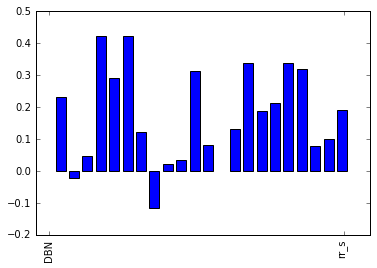

In [20]:
from numpy import arange
bar_heights = correlations[survey_fields]
print(bar_heights)
tick_positions = (1,len(survey_fields))
bar_positions = arange(len(survey_fields))+0.5
fig, ax = plt.subplots()
ax.bar(bar_positions,bar_heights,0.75)
ax.set_xticks(tick_positions)
ax.set_xticklabels(survey_fields, rotation=90)
plt.show()

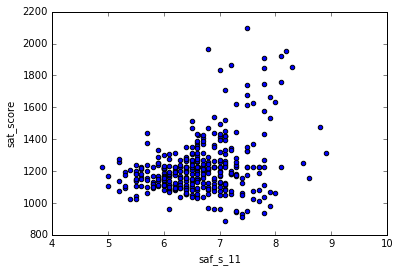

In [21]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

In [23]:
print(combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

In [26]:
import numpy as np
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
print(districts['saf_s_11'].head(2))

0    6.768611
1    6.910660
Name: saf_s_11, dtype: float64


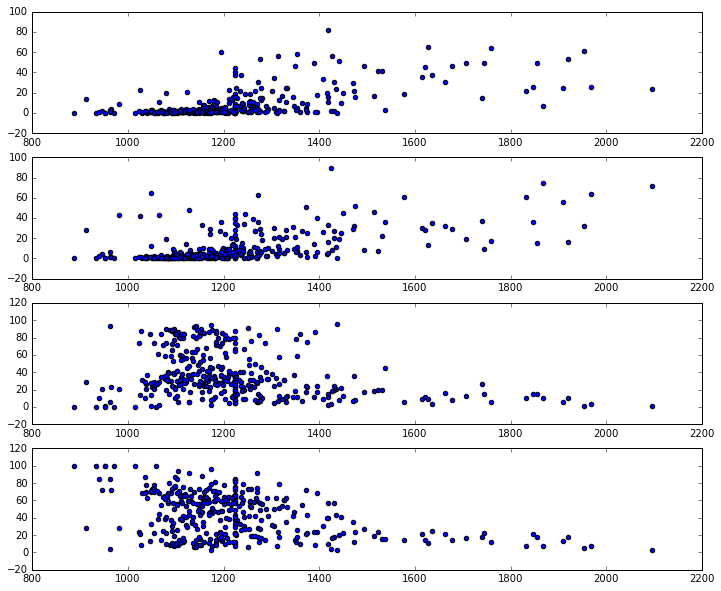

In [30]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)
ax1.scatter(combined["sat_score"], combined["white_per"])
ax2.scatter(combined["sat_score"], combined["asian_per"])
ax3.scatter(combined["sat_score"], combined["black_per"])
ax4.scatter(combined["sat_score"], combined["hispanic_per"])
plt.plot()
plt.show()

In [34]:
schools = combined[combined['hispanic_per'] > 0.1]
schools = schools[schools["sat_score"] > 1800]
print(schools.head(2))

       DBN                     SCHOOL NAME Num of SAT Test Takers  \
5   01M696  BARD HIGH SCHOOL EARLY COLLEGE                    130   
37  02M475          STUYVESANT HIGH SCHOOL                    832   

    SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
5                             624.0                604.0   
37                            679.0                735.0   

    SAT Writing Avg. Score  sat_score     SchoolName  AP Test Takers   \
5                    628.0     1856.0              0       129.028846   
37                   682.0     2096.0  STUYVESANT HS      1510.000000   

    Total Exams Taken     ...      priority05 priority06 priority07  \
5          197.038462     ...               0          0          0   
37        2819.000000     ...               0          0          0   

   priority08  priority09 priority10  \
5           0           0          0   
37          0           0          0   

                                           Location 1   

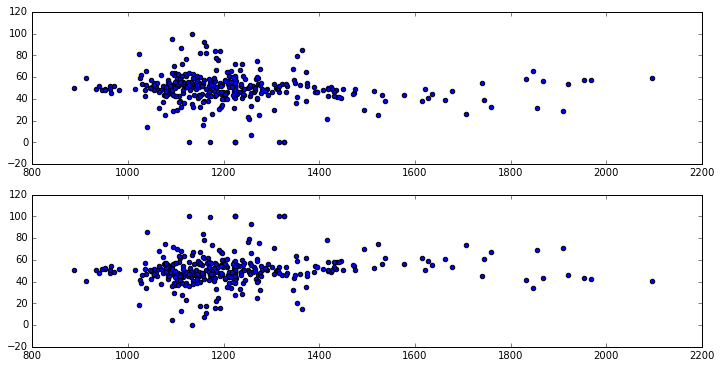

In [36]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.scatter(combined["sat_score"], combined["male_per"])
ax2.scatter(combined["sat_score"], combined["female_per"])
plt.plot()
plt.show()

In [37]:
fem_schools = combined[combined["female_per"] > 0.6]
fem_schools = fem_schools[fem_schools["sat_score"] >  1700]
print(fem_schools.head(2))

       DBN                     SCHOOL NAME Num of SAT Test Takers  \
5   01M696  BARD HIGH SCHOOL EARLY COLLEGE                    130   
26  02M416   ELEANOR ROOSEVELT HIGH SCHOOL                    127   

    SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
5                             624.0                604.0   
26                            572.0                594.0   

    SAT Writing Avg. Score  sat_score                     SchoolName  \
5                    628.0     1856.0                              0   
26                   592.0     1758.0  Eleanor Roosevelt High School   

    AP Test Takers   Total Exams Taken     ...      priority05 priority06  \
5        129.028846         197.038462     ...               0          0   
26       155.000000         235.000000     ...               0          0   

   priority07 priority08  priority09 priority10  \
5           0          0           0          0   
26          0          0           0          0   

        

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

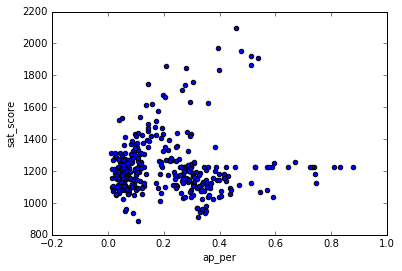

In [43]:
combined['ap_per'] =  combined['AP Test Takers ']/combined['total_enrollment']
print(combined.head())
combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()